# Basic OFDM Example in Python
In this notebook, we will investigate the basic building blocks of an OFDM system at the transmitter and receiver side. OFDM (Orthogonal frequency division multiplexing) is a multicarrier system that is applied in a wide range of wireless transmission systems, such as LTE, WiMAX and DVB-T and DAB. The fundamental concept of a multicarrier system is the division of a high-rate transmitted data stream into several low-rate narrow subcarriers. This way, several advantages are obtained:

Since the symbol duration is inverse proportional to the symbol rate, each subcarrier has relatively long symbols. Long symbols are robust against multipath fading, as it occurs in wireless systems.
When a carrier is in a deep fade due to frequency-selectivity of the channel (i.e. the received energy on this carrier is very low), only the data on this subcarrier is lost, instead of the whole stream.
Multicarrier systems allow easy multi-user resource sharing by allocating different subcarriers to different users.
Consider the following block diagram, which contains fundamental blocks for the OFDM system:

In the following OFDM example, we will go through each block and describe its operation. However, before let us define some parameters that are used for the OFDM system:

The number of subcarriers $K$ describes, how many subcarriers are available in the OFDM system.


In [58]:
pkg load communications
K = 64 % number of OFDM subcarriers

K =  64


The length of the cyclic prefix (CP) denotes the number of samples that are copied from the end of the modulated block to the beginning, to yield a cyclic extension of the block. There is a dedicated article on the CP of OFDM which treats its application in more detail.

In [59]:
CP = K/4  % length of the cyclic prefix: 25% of the block

CP =  16


The number of pilots ***P*** in the OFDM symbol describes, how many carriers are used to transmit known information (i.e. pilots). Pilots will be used at the receiver to estimate the wireless channel between transmitter and receiver. Further, we also define the value that each pilots transmits (which is known to the receiver).

In [60]:
P = 8 % number of pilot carriers per OFDM block
pilotValue = 3 + 3i % The known value each pilot transmits

P =  8
pilotValue =  3 + 3i


Now, let us define some index sets that describe which carriers transmit pilots and which carriers contain payload.



P =  9


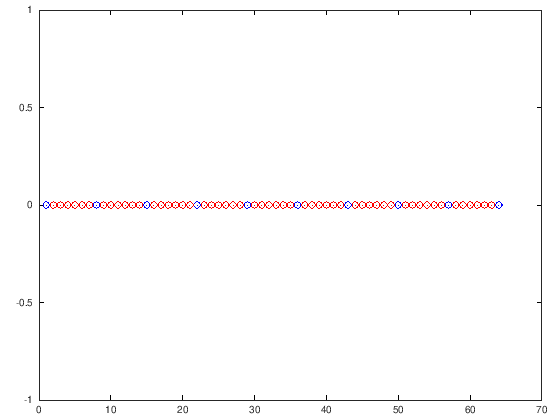

In [61]:
allCarriers = 1:1:K;  # indices of all subcarriers ([0, 1, ... K-1])

pilotCarriers = allCarriers(1:7:end); # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = [pilotCarriers allCarriers(end)];
P = P+1

# data carriers are all remaining carriers
idx               = ismember(allCarriers,pilotCarriers);
dataCarriers      = allCarriers;
dataCarriers(idx) = [];

plot(pilotCarriers, zeros(1,length(pilotCarriers)), 'bo'); hold on; % label='pilot'
plot(dataCarriers,  zeros(1,length(dataCarriers)), 'ro'); hold off; %  label='data'

Let's define the modulation index $μ$ and the corresponding mapping table. We consider 16QAM transmission, i.e. we have $μ=4$ bits per symbol. Furthermore, the mapping from groups of 4 bits to a 16QAM constellation symbol shall be defined in ```mapping_table```.

mu =  4
payloadBits_per_OFDM =  216


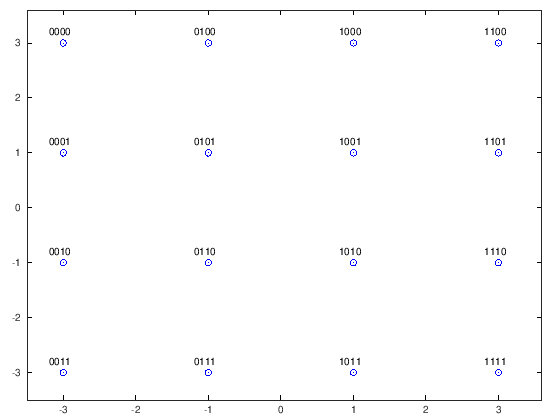

In [62]:
mu = 4 % bits per symbol (i.e. 16QAM)
payloadBits_per_OFDM = length(dataCarriers)*mu  # number of payload bits per OFDM symbol

mapping_table = qammod(0:2^mu-1,2^mu);
maxl          = max(real(mapping_table));
minl          = min(real(mapping_table));
for i = 0 : 2^mu-1
        Q = mapping_table(i+1);
        plot(real(Q), imag(Q), 'bo'); hold on;
        text(real(Q)-0.2, imag(Q)+0.2,dec2bin(i,mu)); hold on;
        axis([minl-0.5 1.2*maxl minl-0.5 1.2*maxl])
end


Above, we have plotted the 16QAM constellation, along with the bit-labels. Note the Gray-mapping, i.e. two adjacent constellation symbols differ only by one bit and the other 3 bits remain the same. This technique helps to minimize bit-errors, in case a wrong constellation symbol is detected: Most probably, symbol errors are "off-by-one" errors, i.e. a symbol next to the correct symbol is detected. Then, only a single bit-error occurs.

The demapping table is simply the inverse mapping of the mapping table:

In [63]:
% demapping_table = {v : k for k, v in mapping_table.items()}

Let us now define the wireless channel between transmitter and receiver. Here, we use a two-tap multipath channel with given impulse response ```channelResponse```. Also, we plot the corresponding frequency response. As we see, the channel is frequency-selective. Further, we define the signal-to-noise ratio in dB, that should occur at the receiver.

SNRdb =  25


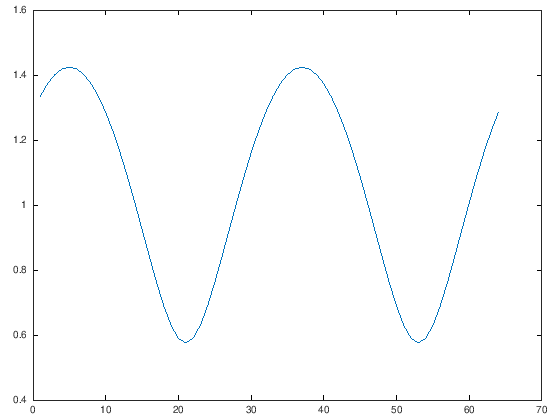

In [64]:
channelResponse = [1, 0, 0.3+0.3j];  % the impulse response of the wireless channel
H_exact = fft(channelResponse, K);
plot(allCarriers, abs(H_exact))

SNRdb = 25  % signal to noise-ratio in dB at the receiver 

Now, that we have defined the necessary parameters for our OFDM example, let us consider the blocks in the OFDM system. Reconsider the block diagram:

It all starts with a random bit sequence $b$. We generate the according bits by a random generator that draws from a Bernoulli distribution with $p=0.5$, i.e. 1 and 0 have equal probability. Note, that the Bernoulli distribution is a special case of the Binomial distribution, when only one draw is considered ($n=1$):

In [65]:
bits = randi([0 1], 1, payloadBits_per_OFDM);
fprintf ("Bits count: %.f \n", length(bits));
disp (["First 20 bits: ",  num2str(bits(1:20))]);
disp (["Mean of bits (should be around 0.5): ", num2str(mean(bits))]);

Bits count: 216 
First 20 bits: 0  0  1  1  1  0  1  1  1  1  0  1  1  0  1  0  0  1  1  1
Mean of bits (should be around 0.5): 0.48148


The ```bits``` are now sent to a serial-to-parallel converter, which groups the bits for the OFDM frame into a groups of $mu$ bits (i.e. one group for each subcarrier):

In [66]:
function bits_SP = SP(bits,dataCarriers,mu)
    % SP converts serial stream of bits to parallel with number of modulation order 
    % SP(all bits, data carriers, bits per symbol)
     bits_SP = reshape(bits,length(dataCarriers), mu);
endfunction
bits_SP = SP(bits,dataCarriers,mu);
disp ("First 5 bit groups: ")
disp (bits_SP(1:5,:))

First 5 bit groups: 
   0   1   1   0
   0   0   1   0
   1   0   0   0
   1   0   1   0
   1   1   1   1


Now, the bits groups are sent to the mapper. The mapper converts the groups into complex-valued constellation symbols according to the ```mapping_table```.

In [67]:
data = bin2dec(num2str(bits_SP));
QAM = mapping_table(data + 1);
disp ("First 5 QAM symbols and bits:");
disp (bits_SP(1:5,:));
disp (QAM(1:5));

First 5 QAM symbols and bits:
   0   1   1   0
   0   0   1   0
   1   0   0   0
   1   0   1   0
   1   1   1   1
  -1 - 1i  -3 - 1i   1 + 3i   1 - 1i   3 - 3i


The next step (which is not shown in the diagram) is the allocation of different subcarriers with data and pilots. For each subcarrier we have defined wether it carries data or a pilot by the arrays ```dataCarriers``` and ```pilotCarriers```. Now, to create the overall OFDM data, we need to put the data and pilots into the OFDM carriers:

In [68]:
OFDM_data(pilotCarriers) = pilotValue;
OFDM_data(dataCarriers) = QAM;

disp (["Number of OFDM carriers in frequency domain: ", num2str(length(OFDM_data))])

Number of OFDM carriers in frequency domain: 64


Now, the OFDM carriers contained in ```OFDM_data``` can be transformed to the time-domain by means of the IDFT operation.

In [69]:
OFDM_time = ifft(OFDM_data);
disp (["Number of OFDM samples in time-domain before CP: ", num2str(length(OFDM_time))])

Number of OFDM samples in time-domain before CP: 64


Subsequently, we add a cyclic prefix to the symbol. This operation concatenates a copy of the last ```CP``` samples of the OFDM time domain signal to the beginning. This way, a cyclic extension is achieved. The CP fulfills two tasks:

It isolates different OFDM blocks from each other when the wireless channel contains multiple paths, i.e. is frequency-selective.
It turns the linear convolution with the channel into a circular one. Only with a circular convolution, we can use the single-tap equalization OFDM is so famous for.
For more information about the CP, you can refer to a dedicated article about the Cyclic Prefix in OFDM.

In [70]:
OFDM_withCP = [OFDM_time(end-CP+1:end) OFDM_time];
disp (["Number of OFDM samples in time domain with CP: ", num2str(length(OFDM_withCP))])

Number of OFDM samples in time domain with CP: 80


Now, the signal is sent to the antenna and sent over the air to the receiver. In between both antennas, there is the wireless channel. We model this channel as a static multipath channel with impulse response channelResponse. Hence, the signal at the receive antenna is the convolution of the transmit signal with the channel response. Additionally, we add some noise to the signal according to the given SNR value:

RX Signal power: 0.1933. Noise power: 0.0006

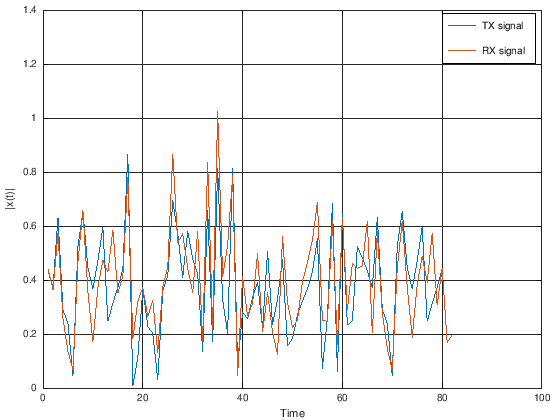

In [71]:
OFDM_TX = OFDM_withCP;
OFDM_RX = conv(OFDM_TX, channelResponse);
signal_power = mean(abs(OFDM_RX.^2));
sigma2 = signal_power * 10.^(-SNRdb/10);  % calculate noise power based on signal power and SNR
noise = sqrt(sigma2/2) * (randn(size(OFDM_RX)) +1j*randn(size(OFDM_RX)));
OFDM_RX = OFDM_RX + noise;
printf ("RX Signal power: %.4f. Noise power: %.4f", signal_power, sigma2)

plot(abs(OFDM_TX)); hold on;
plot(abs(OFDM_RX)); grid on;
xlabel('Time'); ylabel('|x(t)|');
legend('TX signal', 'RX signal')


Now, at the receiver the CP is removed from the signal and a window of K samples is extracted from the received signal.

In [72]:
OFDM_RX_noCP = OFDM_RX(CP+1 : CP+K);

Afterwards, the signal is transformed back to the frequency domain, in order to have the received value on each subcarrier available.



In [73]:
OFDM_demod = fft(OFDM_RX_noCP);

As the next step, the wireless channel needs to be estimated. For illustration purposes, we resort to a simple zero-forcing channel estimation followed by a simple interpolation. The principle of channel estimation is as follows:

The transmit signal contains pilot values at certain pilot carriers. These pilot values and their position in the frequency domain (i.e. the pilot carrier index) are known to the receiver. From the received information at the pilot subcarriers, the receiver can estimate the effect of the wireless channel onto this subcarrier (because it knows what was transmitted and what was received). Hence, the receiver gains information about the wireless channel at the pilot carriers. However, it wants to know what happened at the data carriers. To achieve this, it interpolates the channel values between the pilot carriers to get an estimate of the channel in the data carriers

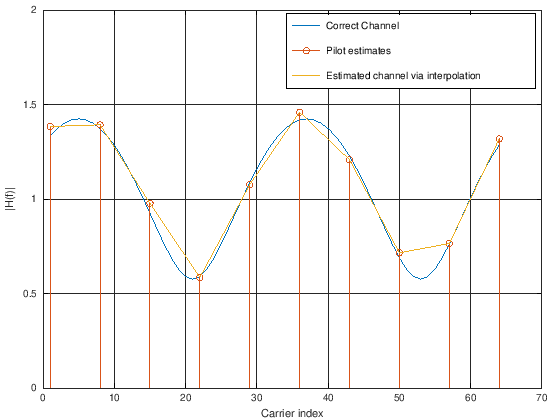

In [74]:
% def channelEstimate(OFDM_demod):
    pilots = OFDM_demod(pilotCarriers);  % extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue; % divide by the transmitted pilot values
    
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    Hest_abs = interp1(pilotCarriers, abs(Hest_at_pilots), allCarriers);
    Hest_phase = interp1(pilotCarriers, angle(Hest_at_pilots), allCarriers);
    Hest = Hest_abs .* exp(1j*Hest_phase);
    
    plot(allCarriers, abs(H_exact)); hold on; 
    stem(pilotCarriers, abs(Hest_at_pilots));
    plot(allCarriers, abs(Hest));
    xlabel('Carrier index'); ylabel('|H(f)|'); 
    legend('Correct Channel', 'Pilot estimates', 'Estimated channel via interpolation');
    grid on; 
    
% Hest = channelEstimate(OFDM_demod)

Now that the channel is estimated at all carriers, we can use this information in the channel equalizer step. Here, for each subcarrier, the influence of the channel is removed such that we get the clear (only noisy) constellation symbols back.

In [75]:
equalized_Hest = OFDM_demod ./ Hest;

The next step (not shown in the diagram) is to extract the data carriers from the equalized symbol. Here, we throw away the pilot carriers, as they do not provide any information, but were used for the channel estimation process.

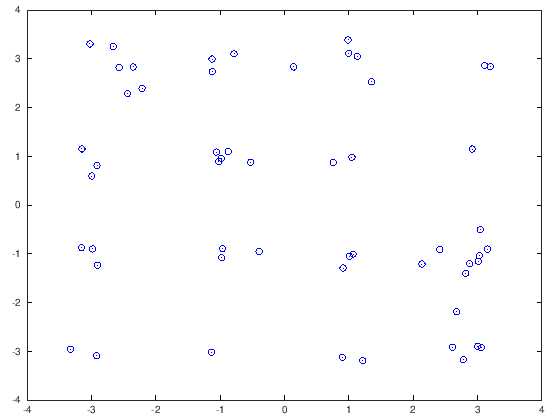

In [76]:
QAM_est = equalized_Hest(dataCarriers);
plot(real(QAM_est), imag(QAM_est), 'bo');

Now, that the constellation is obtained back, we need to send the complex values to the demapper, to transform the constellation points to the bit groups. In order to do this, we compare each received constellation point against each possible constellation point and choose the constellation point which is closest to the received point. Then, we return the bit-group that belongs to this point.

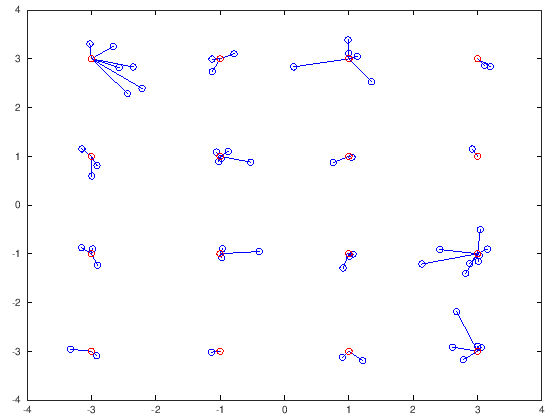

In [77]:
    constellation = repmat(mapping_table,length(dataCarriers),1);
    QAM_rec       = repmat(transpose(QAM_est),1,length(mapping_table));
    # calculate distance of each RX point to each possible point
    dists = abs(QAM_rec - constellation);
    
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    [M,I] = min(dists');
    
    # get back the real constellation point
    const_index = mapping_table(I);
    
    # transform the constellation point into the bit groups
    PS_est   = dec2bin(I-1,mu);

    
for i = 1 : length(QAM_est)    
    plot([real(QAM_est(1,i)), real(const_index(1,i))], [imag(QAM_est(1,i)), imag(const_index(1,i))], 'b-o'); hold on;
    plot(real(const_index), imag(const_index), 'ro')
end


In the diagram above, the blue points are the received QAM points, where as the the red points connected to them are the closest possible constellation points, and the bit groups corresponding to these red points are returned.

Finally, the bit groups need to be converted to a serial stream of bits, by means of parallel to serial conversion.

In [78]:
    bits_est = reshape(PS_est,1,[]) - 48;


Now, that all bits are decoded, let's calculate the bit error rate:



In [79]:
    
    errors = sum(abs(bits - bits_est));
    printf ("Obtained Bit error rate: %.0f ", errors/length(bits));

Obtained Bit error rate: 0 

Fortunately, no bit error occured and the transmission was successful (Reduce the SNR to get some bit errors)



## Source:
https://dspillustrations.com/pages/posts/misc/python-ofdm-example.html